In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt

camL, camR = "cam0", "cam2"

# the parameters in the root are re-optimized in the calibration between cam and lidar
# root = "/home/jc3342/calib_cam_rectify/params/"
root = "./params/"
RotL = np.load(os.path.join(root, camL, "Rot.npy"))
TL = np.load(os.path.join(root, camL, "T.npy"))
RotR = np.load(os.path.join(root, camR, "Rot.npy"))
TR = np.load(os.path.join(root, camR , "T.npy"))

extrinsicsL = np.vstack((np.hstack((RotL, TL)), np.array([[0,0,0,1]])))
extrinsicsR = np.vstack((np.hstack((RotR, TR)), np.array([[0,0,0,1]])))

extrinsic = np.dot(extrinsicsR, np.linalg.inv(extrinsicsL))
R_rel = extrinsic[:3, :3]
T_rel = extrinsic[:3, 3]


In [2]:
def line_split(img, width=3):
    img = img.copy()
    h, w, _ = img.shape
    interval = int(h / 20)
    for i in range(-1, h, interval*2):
        img[i-width:i+width, :, :] = np.array([255])
    for i in range(interval, h, interval*2):
        img[i-width:i+width, :, :] = np.array([128])
    return img
def load_velo_scan(velo_filename, lidar_channels=4, dtype=np.float32):
    scan = np.fromfile(velo_filename, dtype=dtype)
    scan = scan.reshape((-1, lidar_channels))
    return scan

def com(R, ex):
    return np.dot(np.linalg.inv(R), ex)


def rectify_image(left_img, right_img, R, T, instrinsicL, instrinsicR, distCoeffL, distCoeffR):
    assert left_img.shape == right_img.shape
    STEREO_IMG_HEIGHT, STEREO_IMG_WIDTH, _ = left_img.shape
    
#     distCoeffL = distCoeffR = np.zeros(4)

    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1=instrinsicL,
        distCoeffs1=distCoeffL,
        cameraMatrix2=instrinsicR,
        distCoeffs2=distCoeffR,
        imageSize=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        R=R,
        T=T,
        flags=0,
        alpha=0
    )

    map1x, map1y = cv2.initUndistortRectifyMap(
        cameraMatrix=instrinsicL,
        distCoeffs=distCoeffL,
        R=R1,
        newCameraMatrix=P1,
        size=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        m1type=cv2.CV_32FC1)

    map2x, map2y = cv2.initUndistortRectifyMap(
        cameraMatrix=instrinsicR,
        distCoeffs=distCoeffR,
        R=R2,
        newCameraMatrix=P2,
        size=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        m1type=cv2.CV_32FC1)

    extrinsic = np.zeros((3, 4))
    extrinsic[:3, :3] = R
    extrinsic[:3, 3] = T
    extrinsic = np.dot(R1, extrinsic)  # calibrate with R1

    left_img_rect = cv2.remap(left_img, map1x, map1y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    right_img_rect = cv2.remap(right_img, map2x, map2y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    return P1, P2, left_img_rect, right_img_rect, R1, R2, extrinsic

def project_rect_to_image(pts_3d_rect,P):
        ''' Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        '''
        pts_3d_rect = cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(P)) # nx3
        pts_2d[:,0] /= pts_2d[:,2]
        pts_2d[:,1] /= pts_2d[:,2]
        return pts_2d[:,0:2]
    
def cart2hom(pts_3d):
        ''' Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        '''
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
        return pts_3d_hom
    
def load_pcl_from_bin5(bin_file_path):
    bin_pcd = np.fromfile(bin_file_path,dtype=np.float64)
    points = bin_pcd.reshape(-1,5)

    return points[:,:3],points[:,3],points[:,4]

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


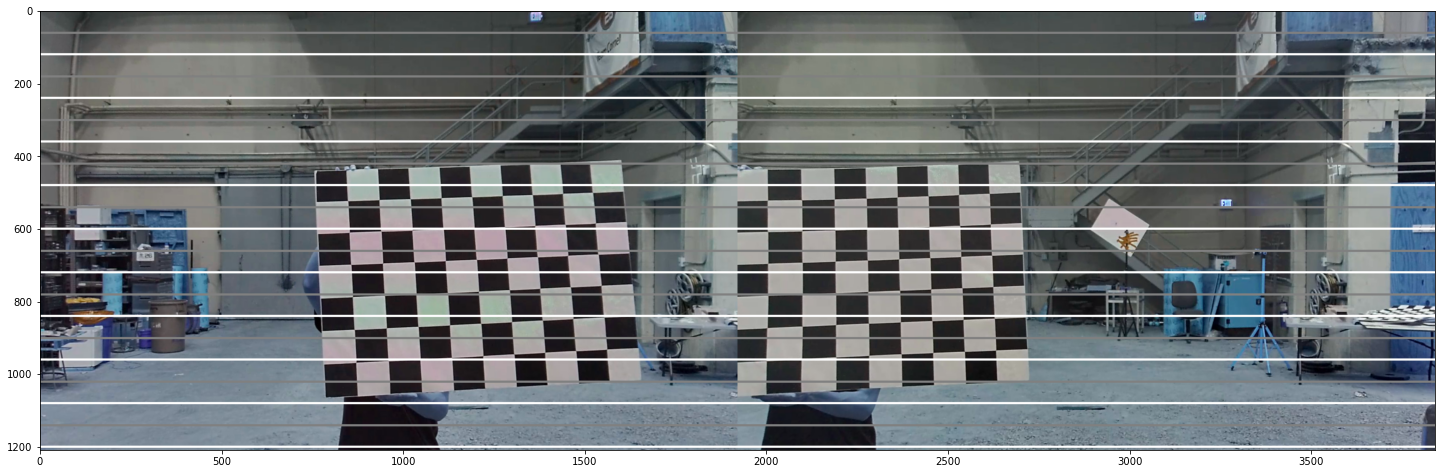

In [6]:
# from tqdm import tqdm
# import glob
# import cv2

# configs = ["02"]
# save_root = "/home/xc429/share/stereo_rectify"

# root = "/home/jc3342/calib_cam/stereo_calib_data"
# img_root ="/home/jc3342/calib_cam/stereo_calib_data"
# intrinsic_root = "/home/jc3342/calib_cam_rectify/params"

# cams = os.listdir(root)


# instrinsicL = np.load(os.path.join(intrinsic_root, camL, "camera_matrix.npy"))
# instrinsicR = np.load(os.path.join(intrinsic_root, camR, "camera_matrix.npy"))

# distCoeffL = np.load(os.path.join(intrinsic_root, camL, "distortion_coefficients.npy"))
# distCoeffR = np.load(os.path.join(intrinsic_root, camR, "distortion_coefficients.npy"))

# #     images = os.listdir(os.path.join(img_root, camL))
# imagesL = sorted(glob.glob(os.path.join(img_root, camL+'/*')))
# imagesR =sorted(glob.glob(os.path.join(img_root, camR+'/*')))

# frames = [8]
# for frame in tqdm(frames):
#     imgL = cv2.imread(imagesL[frame])
#     imgR = cv2.imread(imagesR[frame])
#     calibL, calibR, left_img_rect, right_img_rect, R1, R2, extrinsics = rectify_image(imgL, imgR, R_rel, T_rel, instrinsicL, instrinsicR, distCoeffL, distCoeffR)
#     img_combine = line_split(np.hstack([left_img_rect, right_img_rect]))

# plt.figure(figsize=(25, 10))
# plt.imshow(img_combine)
# plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


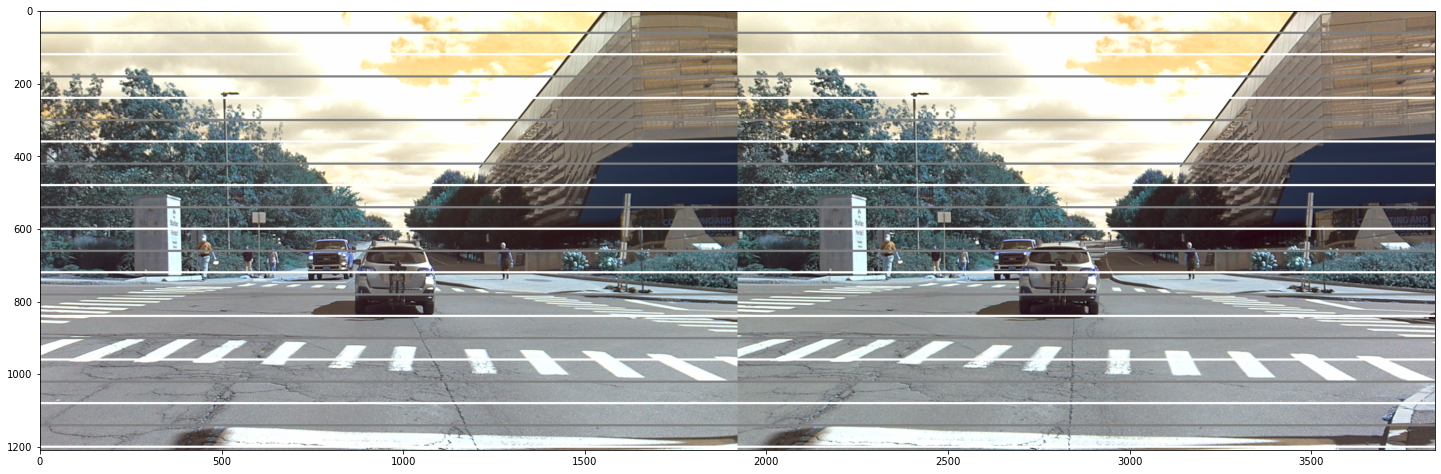

In [7]:
from tqdm import tqdm
import glob
from utils import imu

img_root = "/home/jan268/pedestrian_data/pedestrian_run_b"
lidar_root = "/home/jan268/pedestrian_data/pedestrian_run_b"
# intrinsic_root = "/home/jc3342/calib_cam_rectify/params"
intrinsic_root = "./params"


imagesL = sorted(glob.glob(os.path.join(img_root, camL+'/*')))
imagesR =sorted(glob.glob(os.path.join(img_root, camR+'/*')))
# lidar_files = sorted(glob.glob(os.path.join(lidar_root, 'decoded_lidar/*')))

frames = [10000]

# raw_data_path = "/home/jan268/pedestrian_data/pedestrian_run_b/"
lidar_files, lidar_secs, cam1_files, infos, imu_secs, corrimu_infos, corrimu_secs, bestpos_infos, bestpos_secs = imu.get_infos_os2(lidar_root)

for frame in tqdm(frames):
    imgL = cv2.imread(imagesL[frame])
    imgR = cv2.imread(imagesR[frame])
    pcl = load_velo_scan(lidar_files[frame], lidar_channels=5, dtype=np.float64)
    calibL, calibR, left_img_rect, right_img_rect, R1, R2, extrinsics = rectify_image(imgL, imgR, R_rel, T_rel, instrinsicL, instrinsicR, distCoeffL, distCoeffR)
    img_combine = line_split(np.hstack([left_img_rect, right_img_rect]))

plt.figure(figsize=(25, 10))
plt.imshow(img_combine)
plt.show()

# Project to camL: cam0

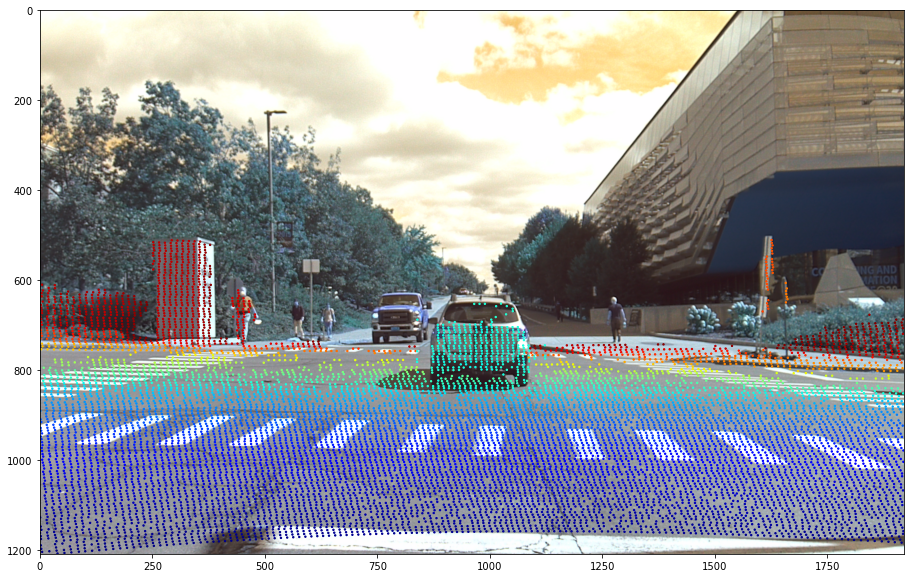

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('jet')



idx = 10000
img = plt.imread(imagesL[idx])
img_file = imagesL[idx]
lidar_file = lidar_files[idx]



pts, intensity, times = load_pcl_from_bin5(lidar_file)

pts_cam_coord = np.dot(RotL,pts.T) + TL.reshape(-1,1) 
pts_cam_coord = np.dot(R1,pts_cam_coord )
pts_cam_coord  = pts_cam_coord.T

pts = pts[pts_cam_coord [:,2]>=0,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]>=0,:]
pts = pts[pts_cam_coord [:,2]<=30,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]<=30,:]

pixels = project_rect_to_image(pts_cam_coord, calibL)


u = pixels[:,0]
v = pixels[:,1]

idx = (u>0)*(u<1920-1)*(v>0)*(v<1208-1)
u = u[idx]
v=v[idx]
plt.figure(figsize = (120,10))
plt.imshow(left_img_rect)
plt.scatter(u,v,c=pts_cam_coord[idx,2], s = 2,cmap = cmap)


# Project to camR: cam2

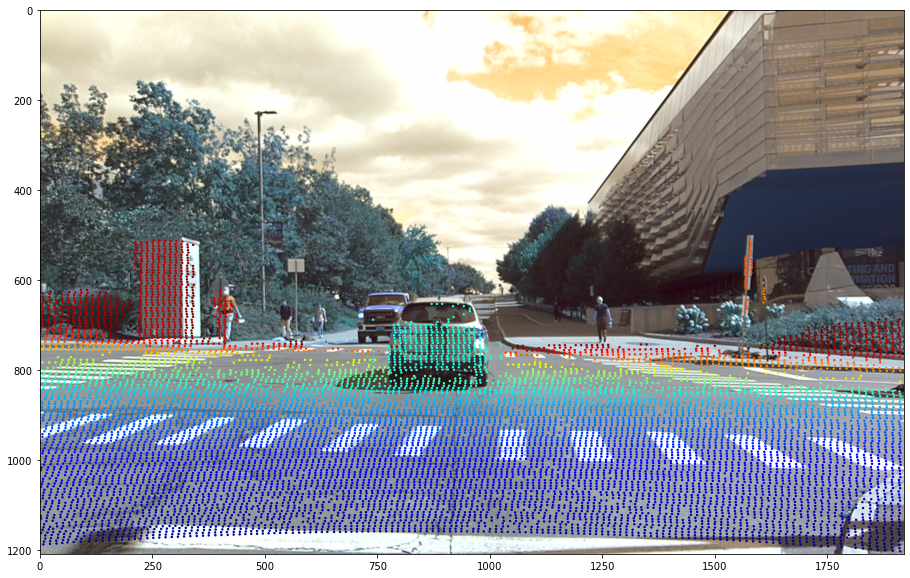

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('jet')



idx = 10000
img = plt.imread(imagesR[idx])
img_file = imagesR[idx]
lidar_file = lidar_files[idx]

def load_pcl_from_bin5(bin_file_path):
    bin_pcd = np.fromfile(bin_file_path,dtype=np.float64)
    points = bin_pcd.reshape(-1,5)

    return points[:,:3],points[:,3],points[:,4]

pts, intensity, times = load_pcl_from_bin5(lidar_file)

pts_cam_coord = np.dot(RotL,pts.T) + TL.reshape(-1,1) 
pts_cam_coord = np.dot(R1,pts_cam_coord )
pts_cam_coord  = pts_cam_coord.T

pts = pts[pts_cam_coord [:,2]>=0,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]>=0,:]
pts = pts[pts_cam_coord [:,2]<=30,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]<=30,:]


pixels = project_rect_to_image(pts_cam_coord, calibR)


u = pixels[:,0]
v = pixels[:,1]

idx = (u>0)*(u<1920-1)*(v>0)*(v<1208-1)
u = u[idx]
v=v[idx]
plt.figure(figsize = (120,10))
plt.imshow(right_img_rect)
plt.scatter(u,v,c=pts_cam_coord[idx,2], s = 2,cmap = cmap)
